In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import glob
import sys
from dotenv import load_dotenv
from tqdm import tqdm
tqdm.pandas()
import math
from sklearn.model_selection import train_test_split
import os
import PIL
import tensorflow.keras.backend as K
sys.path.append('../scripts/helper_functions_cv/tensorflow_helpers/')
from save_weights_every_epoch import CallbackForSavingModelWeights
from multiprocessing import Pool
from sklearn.utils import compute_class_weight
from sklearn.metrics import precision_score, recall_score, accuracy_score
import tensorflow_datasets as tfds
from sklearn.metrics import roc_curve, roc_auc_score
from matplotlib import pyplot
import multiprocessing as mp
sys.path.append('../scripts/')
from find_bad_ones import find_bad_ones

/home/ubuntu/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [3]:
strategy = tf.distribute.get_strategy()
AUTO = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync

In [4]:
load_dotenv('../config_files/dev.env')

True

In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
train_files = glob.glob('../../ml-data-training/ship_segmentation_data/train_v2/*.jpg')

In [7]:
print(len(train_files))

192556


In [8]:
train_csv = pd.read_csv('../../ml-data-training/ship_segmentation_data/train_ship_segmentations_v2.csv')

In [9]:
train_csv.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [10]:
updated_train_csv = train_csv.groupby('ImageId')['EncodedPixels'].apply(list).reset_index()

In [11]:
# (updated_train_csv['EncodedPixels'].values.tolist()[0][0])

In [12]:
def create_classification_labels(data):
    try:
        if math.isnan(data[0]) == True:
            return 0
    except:
        return 1
    # else:
    #     return 1

In [13]:
updated_train_csv['class_labels'] = updated_train_csv['EncodedPixels'].progress_apply(create_classification_labels)

100%|██████████| 192556/192556 [00:00<00:00, 267936.62it/s]


In [14]:
updated_train_csv.head()

,ImageId,EncodedPixels,class_labels
0,00003e153.jpg,[nan],0
1,0001124c7.jpg,[nan],0
2,000155de5.jpg,[264661 17 265429 33 266197 33 266965 33 26773...,1
3,000194a2d.jpg,[360486 1 361252 4 362019 5 362785 8 363552 10...,1
4,0001b1832.jpg,[nan],0


In [15]:
updated_train_csv['fixed_paths'] = updated_train_csv['ImageId'].progress_apply(lambda x: f"../../ml-data-training/ship_segmentation_data/train_v2/" + x)

100%|██████████| 192556/192556 [00:00<00:00, 307626.54it/s]


In [16]:
for x in updated_train_csv['fixed_paths'].values.tolist():
    if os.path.exists(x) == False:
        print(x)

In [17]:
to_check = updated_train_csv['fixed_paths'].values.tolist()

In [18]:
issues = find_bad_ones(to_check)

In [19]:
updated_train_csv = updated_train_csv[updated_train_csv.fixed_paths != issues[0]]

In [20]:
def split_datasets(data, test_size = 0.01):
    train, test = train_test_split(data, test_size = test_size, random_state = 42) 
    train, val = train_test_split(train, test_size = test_size, random_state = 42)
    return train, val, test

In [21]:
train, val, test = split_datasets(updated_train_csv)

In [22]:
def read_train_imgs(img, label, shape):
    img = tf.io.read_file(img)
    img = tf.image.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = shape)
    img = img / 255
    return img, label

In [36]:
def get_data(data, shape = (256, 256), shuffle = True, repeat = True, batch = True, batch_size = 32):
    imgs, labels = data['fixed_paths'].values.tolist(), data['class_labels'].values.tolist()
    shapes = [shape for x in range(len(imgs))]
    tensor = tf.data.Dataset.from_tensor_slices((imgs, labels, shapes))
    tensor = tensor.cache()
    if repeat:
        tensor = tensor.repeat()
    if shuffle:
        tensor = tensor.shuffle(8048 * 1)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        tensor = tensor.with_options(opt)
    tensor = tensor.map(read_train_imgs)
    if batch:
        tensor = tensor.batch(batch_size * REPLICAS)
    tensor = tensor.prefetch(AUTO)
    return tensor

In [37]:
train_dataset = get_data(train)
val_dataset = get_data(val)
test_dataset = get_data(test)

In [38]:
def create_model(model_name, shape):
    with strategy.scope():
        input_layer = tf.keras.Input(shape = shape)
        construct = getattr(keras.applications, model_name)
        mid_layer = construct(include_top = False, 
                            weights = None, 
                            pooling = 'avg')(input_layer)
        last_layer = keras.layers.Dense(1, activation = 'sigmoid')(mid_layer)
        model = keras.Model(input_layer, last_layer)
    return model
def compile_new_model(model):
    with strategy.scope():
        loss = keras.losses.BinaryCrossentropy()
        optimizer = keras.optimizers.SGD()
        prec = keras.metrics.Precision(name = 'prec')
        rec = keras.metrics.Recall(name = 'rec')
        model.compile(
            loss = loss,
            optimizer = optimizer,
            metrics = [prec, rec]
        )
    return model

In [39]:
temp = [x for x in train['class_labels'].values.tolist()]

In [40]:
K.clear_session()
log_dir = f"{os.environ['tb_path']}classification/res50_baseline/"
if os.path.exists(log_dir) == False:
    os.makedirs(log_dir)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
weights_path = '../../weights/classification/res50_baseline/'
weights_save = CallbackForSavingModelWeights(weights_path)
batch_size = 512
train_dataset = get_data(train)
val_dataset = get_data(val, repeat = False, shuffle = False)
model = create_model('ResNet50', (256, 256, 3))
model = compile_new_model(model)
model_hist = model.fit(
    train_dataset,
    validation_data = val_dataset,
    verbose = 1,
    epochs = 100,
    steps_per_epoch = len(train) // (batch_size * REPLICAS),
    callbacks = [
        tensorboard_callback,
        weights_save
    ]
)

Epoch 1/100
368/368 [==============================] - 68s 175ms/step - loss: 0.6937 - prec: 0.3577 - rec: 0.1659 - val_loss: 0.6603 - val_prec: 0.0000e+00 - val_rec: 0.0000e+00
Epoch 2/100
368/368 [==============================] - 64s 173ms/step - loss: 0.5411 - prec: 0.4730 - rec: 0.2504 - val_loss: 0.6156 - val_prec: 0.6250 - val_rec: 0.0232
Epoch 3/100
368/368 [==============================] - 64s 173ms/step - loss: 0.4931 - prec: 0.5512 - rec: 0.2998 - val_loss: 0.8718 - val_prec: 0.4091 - val_rec: 0.5638
Epoch 4/100
368/368 [==============================] - 64s 173ms/step - loss: 0.4239 - prec: 0.6443 - rec: 0.3906 - val_loss: 0.4839 - val_prec: 0.9333 - val_rec: 0.1299
Epoch 5/100
368/368 [==============================] - 64s 173ms/step - loss: 0.3922 - prec: 0.7167 - rec: 0.4610 - val_loss: 0.9512 - val_prec: 0.4413 - val_rec: 0.7146
Epoch 6/100
368/368 [==============================] - 64s 173ms/step - loss: 0.3700 - prec: 0.7657 - rec: 0.4893 - val_loss: 0.5930 - val_pre

KeyboardInterrupt: 

In [27]:
K.clear_session()
log_dir = f"{os.environ['tb_path']}classification/renset_50_class_weights_v3/"
if os.path.exists(log_dir) == False:
    os.makedirs(log_dir)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
weights_path = '../../weights/classification/renset_50_class_weights/'
weights_save = CallbackForSavingModelWeights(weights_path, epoch_number = 30)
batch_size = 102
train_dataset = get_data(train)
val_dataset = get_data(val, repeat = False, shuffle = False)
model = create_model('ResNet50', (256, 256, 3))
model = compile_new_model(model)
model.load_weights('../../weights/classification/renset_50_class_weights/30.h5')
model_hist = model.fit(
    train_dataset,
    validation_data = val_dataset,
    verbose = 1,
    epochs = 60,
    steps_per_epoch = len(train) // (batch_size * REPLICAS),
    callbacks = [
        tensorboard_callback,
        weights_save
    ],
    class_weight = class_weights
)

Epoch 1/60
1850/1850 [==============================] - 127s 65ms/step - loss: 0.0976 - prec: 0.8751 - rec: 0.9697 - val_loss: 0.2176 - val_prec: 0.7784 - val_rec: 0.9861
Epoch 2/60
1850/1850 [==============================] - 120s 65ms/step - loss: 0.1053 - prec: 0.8666 - rec: 0.9645 - val_loss: 0.1974 - val_prec: 0.7665 - val_rec: 0.9675
Epoch 3/60
1850/1850 [==============================] - 120s 65ms/step - loss: 0.1040 - prec: 0.8690 - rec: 0.9659 - val_loss: 0.1906 - val_prec: 0.7706 - val_rec: 0.9745
Epoch 4/60
1850/1850 [==============================] - 120s 65ms/step - loss: 0.0949 - prec: 0.8790 - rec: 0.9713 - val_loss: 0.1548 - val_prec: 0.8584 - val_rec: 0.9281
Epoch 5/60
1850/1850 [==============================] - 120s 65ms/step - loss: 0.0971 - prec: 0.8724 - rec: 0.9700 - val_loss: 0.1482 - val_prec: 0.8525 - val_rec: 0.9652
Epoch 6/60
1850/1850 [==============================] - 120s 65ms/step - loss: 0.0958 - prec: 0.8761 - rec: 0.9688 - val_loss: 0.1251 - val_prec:

KeyboardInterrupt: 

Best weight so far:
'../../weights/classification/renset_50_class_weights/30.h5'

In [28]:
model = create_model('ResNet50', (256, 256, 3))
model = compile_new_model(model)
model.load_weights('../../weights/classification/renset_50_class_weights/30.h5')

In [30]:
train_dataset = get_data(train, shuffle = False, repeat = False)
val_dataset = get_data(val, repeat = False, shuffle = False)
test_dataset = get_data(test, repeat = False, shuffle = False)

In [31]:
model.evaluate(train_dataset, verbose = 1)

5898/5898 [==============================] - 135s 23ms/step - loss: 0.0862 - prec: 0.9092 - rec: 0.9436


[0.08624683320522308, 0.9091686010360718, 0.9435957670211792]

In [32]:
model.evaluate(val_dataset, verbose = 1)

60/60 [==============================] - 1s 22ms/step - loss: 0.1099 - prec: 0.8937 - rec: 0.9165


[0.10993099212646484, 0.8936651349067688, 0.9164733290672302]

In [33]:
model.evaluate(test_dataset, verbose = 1)

61/61 [==============================] - 2s 25ms/step - loss: 0.0917 - prec: 0.9249 - rec: 0.9249


[0.09167337417602539, 0.9248826503753662, 0.9248826503753662]

In [77]:
# Train datasets
train_dataset = get_data(train, shuffle = False, repeat = False)
train_imgs = train_dataset.map(lambda img, label: img)
train_label = train_dataset.map(lambda img, label: label)
# val datasets
val_dataset = get_data(val, shuffle = False, repeat = False)
val_imgs = val_dataset.map(lambda img, label: img)
val_label = val_dataset.map(lambda img, label: label)
# Test datasets
test_dataset = get_data(test, shuffle = False, repeat = False)
test_imgs = test_dataset.map(lambda img, label: img)
test_label = test_dataset.map(lambda img, label: label)

In [35]:
train_pred = model.predict(train_imgs, verbose=1)
train_pred = [x[0] for x in train_pred]
train_pred_copy = train_pred.copy()
train_pred_copy = [1 if x > 0.5 else 0 for x in train_pred_copy]

5898/5898 [==============================] - 124s 21ms/step


In [39]:
train_label_as_list = []
for lab in tfds.as_numpy(train_label.unbatch()):
    train_label_as_list.append(lab)

In [69]:
print(f'Precision score: {precision_score(train_label_as_list, train_pred_copy)}')
print(f'Recall score: {recall_score(train_label_as_list, train_pred_copy)}')
print(f'Accuracy score: {accuracy_score(train_label_as_list, train_pred_copy)}')

Precision score: 0.9091686307130644
Recall score: 0.9435957696827262
Accuracy score: 0.9667076440478588


Try with moving threshold value

In [ ]:
# roc curve for logistic regression model with optimal threshold
from numpy import sqrt
from numpy import argmax
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from matplotlib import pyplot
# generate dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
 n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=4)
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2, stratify=y)
# fit a model
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)
# predict probabilities
yhat = model.predict_proba(testX)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(testy, yhat)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

In [61]:
fpr, tpr, thresholds = roc_curve(train_label_as_list, train_pred)
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.271509, G-Mean=0.963


Calculate AUC score

In [66]:
roc_auc_score(train_label_as_list, train_pred)

0.9935867413921614

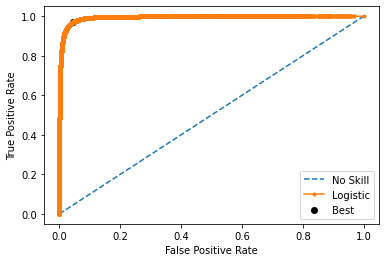

In [64]:
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

Best threshold for this experiment is: 0.2715

In [70]:
train_pred_copy = train_pred.copy()
train_pred_copy = [1 if x > 0.02715 else 0 for x in train_pred_copy]

In [72]:
print(f'Precision score: {precision_score(train_label_as_list, train_pred_copy)}')
print(f'Recall score: {recall_score(train_label_as_list, train_pred_copy)}')
print(f'Accuracy score: {accuracy_score(train_label_as_list, train_pred_copy)}')

Precision score: 0.6788173150828305
Recall score: 0.9954435358162066
Accuracy score: 0.8949248100380454


So this is penalizing very heavily the negatie ones.

Metrics generating for validation dataset

In [73]:
val_pred = model.predict(val_imgs, verbose=1)
val_pred = [x[0] for x in val_pred]
val_pred_copy = val_pred.copy()
val_pred_copy = [1 if x > 0.5 else 0 for x in val_pred_copy]

60/60 [==============================] - 2s 30ms/step


In [74]:
val_label_as_list = []
for lab in tfds.as_numpy(val_label.unbatch()):
    val_label_as_list.append(lab)

In [75]:
print(f'Precision score: {precision_score(val_label_as_list, val_pred_copy)}')
print(f'Recall score: {recall_score(val_label_as_list, val_pred_copy)}')
print(f'Accuracy score: {accuracy_score(val_label_as_list, val_pred_copy)}')

Precision score: 0.8936651583710408
Recall score: 0.9164733178654292
Accuracy score: 0.9564761405348715


Metrics for test datasets

In [78]:
test_pred = model.predict(test_imgs, verbose=1)
test_pred = [x[0] for x in test_pred]
test_pred_copy = test_pred.copy()
test_pred_copy = [1 if x > 0.5 else 0 for x in test_pred_copy]

61/61 [==============================] - 1s 21ms/step


In [79]:
test_label_as_list = []
for lab in tfds.as_numpy(test_label.unbatch()):
    test_label_as_list.append(lab)

In [80]:
print(f'Precision score: {precision_score(test_label_as_list, test_pred_copy)}')
print(f'Recall score: {recall_score(test_label_as_list, test_pred_copy)}')
print(f'Accuracy score: {accuracy_score(test_label_as_list, test_pred_copy)}')

Precision score: 0.9248826291079812
Recall score: 0.9248826291079812
Accuracy score: 0.9667705088265836
